In [1]:
import IJulia
import Base64

# The julia kernel has built in support for Revise.jl, so this is the 
# recommended approach for long-running sessions:
# https://github.com/JuliaLang/IJulia.jl/blob/9b10fa9b879574bbf720f5285029e07758e50a5e/src/kernel.jl#L46-L51

# Users should enable revise within .julia/config/startup_ijulia.jl:
# https://timholy.github.io/Revise.jl/stable/config/#Using-Revise-automatically-within-Jupyter/IJulia-1

# clear console history
IJulia.clear_history()

fig_width = 10
fig_height = 5
fig_format = :retina
fig_dpi = 96

# no retina format type, use svg for high quality type/marks
if fig_format == :retina
  fig_format = :svg
elseif fig_format == :pdf
  fig_dpi = 96
  # Enable PDF support for IJulia
  IJulia.register_mime(MIME("application/pdf"))
end

# convert inches to pixels
fig_width = fig_width * fig_dpi
fig_height = fig_height * fig_dpi

# Intialize Plots w/ default fig width/height
try
  import Plots

  # Plots.jl doesn't support PDF output for versions < 1.28.1
  # so use png (if the DPI remains the default of 300 then set to 96)
  if (Plots._current_plots_version < v"1.28.1") & (fig_format == :pdf)
    Plots.gr(size=(fig_width, fig_height), fmt = :png, dpi = fig_dpi)
  else
    Plots.gr(size=(fig_width, fig_height), fmt = fig_format, dpi = fig_dpi)
  end
catch e
  # @warn "Plots init" exception=(e, catch_backtrace())
end

# Initialize CairoMakie with default fig width/height
try
  import CairoMakie

  # CairoMakie's display() in PDF format opens an interactive window
  # instead of saving to the ipynb file, so we don't do that.
  # https://github.com/quarto-dev/quarto-cli/issues/7548
  if fig_format == :pdf
    CairoMakie.activate!(type = "png")
  else
    CairoMakie.activate!(type = string(fig_format))
  end
  CairoMakie.update_theme!(resolution=(fig_width, fig_height))
catch e
    # @warn "CairoMakie init" exception=(e, catch_backtrace())
end
  
# Set run_path if specified
try
  run_path = "L1VzZXJzL211bGxpbnNqL0Ryb3Bib3gvVGVhY2hpbmcvRUNPTjQ1MzgvbGVjdHVyZXM="
  if !isempty(run_path)
    run_path = String(Base64.base64decode(run_path))
    cd(run_path)
  end
catch e
  @warn "Run path init:" exception=(e, catch_backtrace())
end


# emulate old Pkg.installed beahvior, see
# https://discourse.julialang.org/t/how-to-use-pkg-dependencies-instead-of-pkg-installed/36416/9
import Pkg
function isinstalled(pkg::String)
  any(x -> x.name == pkg && x.is_direct_dep, values(Pkg.dependencies()))
end

# ojs_define
if isinstalled("JSON") && isinstalled("DataFrames")
  import JSON, DataFrames
  global function ojs_define(; kwargs...)
    convert(x) = x
    convert(x::DataFrames.AbstractDataFrame) = Tables.rows(x)
    content = Dict("contents" => [Dict("name" => k, "value" => convert(v)) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
elseif isinstalled("JSON")
  import JSON
  global function ojs_define(; kwargs...)
    content = Dict("contents" => [Dict("name" => k, "value" => v) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
else
  global function ojs_define(; kwargs...)
    @warn "JSON package not available. Please install the JSON.jl package to use ojs_define."
  end
end


# don't return kernel dependencies (b/c Revise should take care of dependencies)
nothing


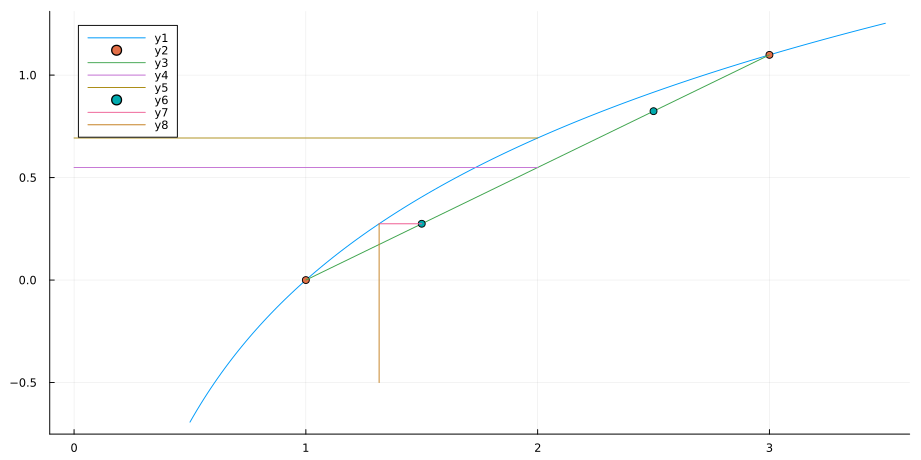

In [2]:
using Plots
#| echo: false
y_L = 1.0
y_H = 3.0
π = 0.75  # probability of low income for low type, etc

C_star = 2.
W_0 = 0.5*log(y_L) + 0.5*log(y_H)
U_L = π*log(y_L) + (1-π)*log(y_H)
U_H = π*log(y_H) + (1-π)*log(y_L)
E_L = π*y_L+(1-π)*y_H
E_H = π*y_H+(1-π)*y_L
c_L = exp(U_L)
c_H = exp(U_H)
U_star = log(C_star)

y_range = range(0.5, 3.5, length=200)
plot(y_range, log.(y_range))
scatter!([y_L,y_H],[log(y_L),log(y_H)])
plot!([y_L,y_H],[log(y_L),log(y_H)])
plot!([0,C_star],[W_0,W_0])
plot!([0,C_star],[U_star,U_star])
scatter!([E_L,E_H],[U_L,U_H])
plot!([c_L,E_L],[U_L,U_L])
plot!([c_L,c_L],[-0.5,U_L])

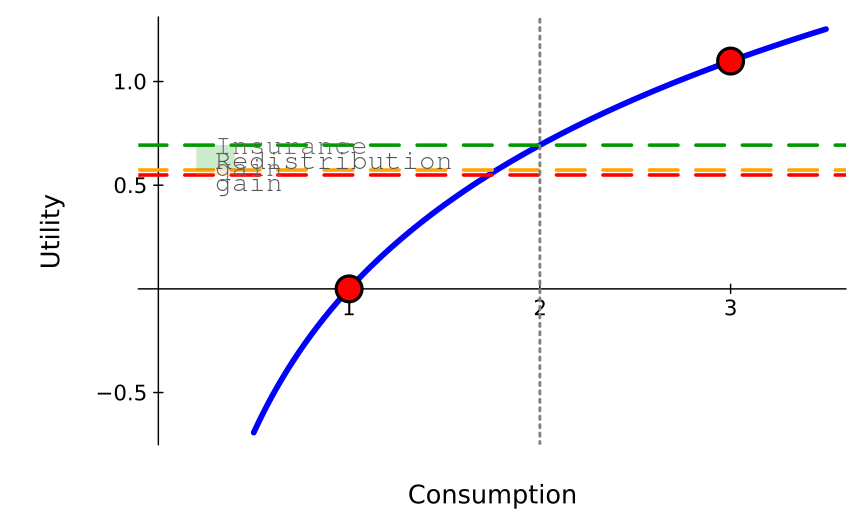

In [3]:
#| echo: false

using Plots

# Parameters for the example
y_L = 1.0
y_H = 3.0
π = 0.7  # probability of low income for low type

# Calculate key values
E_y = 0.5 * y_L + 0.5 * y_H  # average income
E_log_y = 0.5 * log(y_L) + 0.5 * log(y_H)  # E[u(y)] in laissez-faire
C_star = E_y  # optimal consumption (perfect insurance)
log_C_star = log(C_star)  # u(C*)

# Certainty equivalents for each type in laissez-faire
c_bar_L = exp(π * log(y_L) + (1-π) * log(y_H))
c_bar_H = exp((1-π) * log(y_L) + π * log(y_H))
C_bar = 0.5 * c_bar_L + 0.5 * c_bar_H  # average certainty equivalent
log_C_bar = log(C_bar)  # u(C̄)

# Create the plot with cleaner styling
y_range = range(0.5, 3.5, length=200)
p = plot(y_range, log.(y_range),
     label="u(c) = log(c)",
     linewidth=4,
     color=:blue,
     xlabel="Consumption",
     ylabel="Utility",
     legend=:topleft,
     size=(900, 550),
     grid=false,
     framestyle=:origin,
     thickness_scaling=1.5,
     legendfontsize=11,
     guidefontsize=12,
     tickfontsize=10)

# Mark the income levels
scatter!([y_L, y_H], [log(y_L), log(y_H)],
         markersize=10,
         color=:red,
         markerstrokewidth=2,
         label="Income realizations (yₗ, yₕ)")

# E[log(y)] - expected utility in laissez-faire
hline!([E_log_y],
       linestyle=:dash,
       color=:red,
       linewidth=2.5,
       label="E[log(y)] - Laissez-faire")

# log(C̄) - utility of average certainty equivalent
hline!([log_C_bar],
       linestyle=:dash,
       color=:orange,
       linewidth=2.5,
       label="log(C̄) - With redistribution")

# log(C*) - utility under perfect insurance
hline!([log_C_star],
       linestyle=:dash,
       color=RGB(0, 0.6, 0),
       linewidth=2.5,
       label="log(C*) - Perfect insurance")

# Add vertical line at E[y]
vline!([E_y],
       linestyle=:dot,
       color=:gray,
       linewidth=2,
       label="E[y]")

# Add shaded regions for the gains
y_shade = [0.2, 0.2, 0.4, 0.4]
# Redistribution gain
plot!(y_shade, [E_log_y, log_C_bar, log_C_bar, E_log_y],
      fillrange=[E_log_y, E_log_y, E_log_y, E_log_y],
      fillalpha=0.2,
      fillcolor=:orange,
      label="",
      linewidth=0)
# Insurance gain
plot!(y_shade, [log_C_bar, log_C_star, log_C_star, log_C_bar],
      fillrange=[log_C_bar, log_C_bar, log_C_bar, log_C_bar],
      fillalpha=0.2,
      fillcolor=RGB(0, 0.6, 0),
      label="",
      linewidth=0)

# Add text annotations for the gains
annotate!(0.3, (E_log_y + log_C_bar)/2,
          text("Redistribution\ngain", :orange, :left, 10, :bold))
annotate!(0.3, (log_C_bar + log_C_star)/2,
          text("Insurance\ngain", RGB(0, 0.6, 0), :left, 10, :bold))

plot!(legend=false)